In [1]:
import os
import SimpleITK as sitk 
import pandas as pds 
import numpy as np 
from math import ceil 
import pickle
from tqdm import tqdm
from collections import Counter
from tools import resample_multiprocesses

import sklearn.metrics as skMetrics
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
csvFile = pds.read_csv(os.path.join("..", "data", "stoic2021", "reference.csv"))
dataInfo = {}
exclusivedFname = []

for fname, isCovid, isSevere in zip(csvFile["PatientID"], csvFile["probCOVID"], csvFile["probSevere"]):
    if fname in exclusivedFname:
        continue

    dataInfo[fname] = [isCovid, isSevere]

with open(os.path.join("..", "data", "stoic2021", "LabelInfo.pth"), "wb") as f:
    pickle.dump(dataInfo, f)

In [ ]:
'''
Pretrain Wrap
'''

import torch
import torch.nn as nn
from model.resnet import ResNet, BasicBlock

networkTag = "resnet_10"

resnet = nn.DataParallel(ResNet(BasicBlock, [1, 1, 1, 1], 0, 0, 0, 2))
netPrams = resnet.state_dict()
params = torch.load(os.path.join("weights", "{}.pth".format(networkTag)), map_location="cpu")

params = {k: v for k, v in params['state_dict'].items() if k in resnet.state_dict().keys()}
netPrams.update(params)

resnet.load_state_dict(netPrams)

results = {
    "params": resnet.module.state_dict(),
}

torch.save(results, os.path.join("..", "record", "pretrain", "{}.pth".format(networkTag)))

In [ ]:
# '''
# Arrange Model
# '''

# fold_num = 5
# dataset_name = 'TAPVC'
# data_spacing = '1_1_1'
# model_tag = '{}_coarse_{}'.format(dataset_name, "tversky_0.3_0.7")

# model_path = os.path.join('..', 'record', '{}_coarse_tversky'.format(dataset_name))

# for i in range(fold_num):
#     curr_path = os.path.join('..', 'record', '{}_coarse_fold{}.pth'.format(dataset_name, i))
#     if os.path.exists(curr_path) == False:
#         os.mkdir(curr_path)
#         os.mkdir(os.path.join(curr_path, 'data'))
#         os.mkdir(os.path.join(curr_path, 'model'))

#     os.link(os.path.join(model_path, '{}_fold{}.pth'.format(model_tag, i), 'model', 'best_model.pth'), os.path.join(curr_path, 'model', 'best_model.pth'))


In [ ]:
'''
all data 
PA:1
'''

# data_path = os.path.join('..', 'data', 'Resampled')
# target_path = os.path.join('..', 'data', 'all_data')

# data_path = os.path.abspath(data_path)
# target_path = os.path.abspath(target_path)

# if os.path.exists(target_path) == False:
#     os.mkdir(target_path)

# for s in os.listdir(data_path):
#     if os.path.exists(os.path.join(target_path, s)) == False:
#         os.mkdir(os.path.join(target_path, s))

#     PV = sitk.ReadImage(os.path.join(data_path, s, 'PV.nii.gz'))
#     LA = sitk.ReadImage(os.path.join(data_path, s, 'LA.nii.gz'))

#     spacing = PV.GetSpacing()
#     PV = sitk.GetArrayFromImage(PV)
#     LA = sitk.GetArrayFromImage(LA)

#     label = np.zeros_like(PV)
#     label[PV.astype('bool')] = 1
#     label[LA.astype('bool')] = 2

#     label = label.astype('uint8')
#     label = sitk.GetImageFromArray(label)
#     label.SetSpacing(spacing)

#     sitk.WriteImage(label, os.path.join(target_path, s, 'mask.nii.gz'))
#     os.symlink(os.path.join(data_path, s, 'image.nii.gz'), os.path.join(target_path, s, 'im.nii.gz'))


    

In [ ]:
# '''
# data information
# '''

data_path = os.path.join('..', 'data', 'stoic2021', 'data_2')

data = {
    'fname':[],
    'size_x':[],
    'size_y':[],
    'size_z':[],
    'spacing_x':[],
    'spacing_y':[],
    'spacing_z':[],
    'I_max':[],
    'I_min':[],
    'I_mid':[],
    'I_mean':[],
    'I_var':[]
}

for fname in tqdm(os.listdir(data_path)):
    image = sitk.ReadImage(os.path.join(data_path, fname))

    size_x, size_y, size_z = image.GetSize()
    spacing_x, spacing_y, spacing_z = image.GetSpacing()

    image = sitk.GetArrayFromImage(image)

    data['fname'].append(fname)
    data['size_x'].append(size_x)
    data['size_y'].append(size_y)
    data['size_z'].append(size_z)
    data['spacing_x'].append(spacing_x)
    data['spacing_y'].append(spacing_y)
    data['spacing_z'].append(spacing_z)
    data['I_max'].append(image.max())
    data['I_min'].append(image.min())
    data['I_mid'].append(np.median(image))
    data['I_mean'].append(image.mean())
    data['I_var'].append(image.var())

data = pds.DataFrame(data)
data.to_csv('data_inform.csv')


In [ ]:
# test_fname = []

# for fname in os.listdir('../data/7.4newdata'):
#     test_fname.append(fname)

# with open(os.path.join('../data/splits', 'test.pth'), 'wb') as f:
#     pickle.dump(test_fname, f)


In [ ]:
'''
Data preprocess
'''

data_path = os.path.join('..', 'data', 'stoic2021', 'data')
target_path = os.path.join('..', 'data', 'stoic2021', 'data_3')

if os.path.exists(target_path) == False:
    os.mkdir(target_path)

path_list = []
for fname in os.listdir(data_path):
    path_list.append(os.path.join(data_path, fname))

resample_multiprocesses.Resample(path_list, target_path, 8)

In [ ]:
'''
data split
'''

fold_num = 5

tapvcInfo = {}
with open(os.path.join("..", "data", "stoic2021", "LabelInfo.pth"), "rb") as f:
    tapvcInfo = pickle.load(f)

fname_list = list(tapvcInfo.keys())
label00List = []
label10List = []
label11List = []

for patientName in fname_list:
    if 0 == tapvcInfo[patientName][0] and 0 == tapvcInfo[patientName][1]:
        label00List.append(patientName)
    elif 1 == tapvcInfo[patientName][0] and 0 == tapvcInfo[patientName][1]:
        label10List.append(patientName)
    elif 1 == tapvcInfo[patientName][0] and 1 == tapvcInfo[patientName][1]:
        label11List.append(patientName)
    else:
        print("Invalid item: {}".format(patientName))

print(len(label00List), len(label10List), len(label11List))

target_path = os.path.join('..', 'data', 'stoic2021', 'splits_cls')
# fname_list = sorted(fname_list, key = lambda x: x)

if os.path.exists(target_path) == False:
    os.mkdir(target_path)

fold_num00_list = []
fold_num10_list = []
fold_num11_list = []
for i in range(fold_num):
    if i == fold_num - 1:
        fold_num00_list.append(len(label00List) - sum(fold_num00_list))
        fold_num10_list.append(len(label10List) - sum(fold_num10_list))
        fold_num11_list.append(len(label11List) - sum(fold_num11_list))
    else:
        fold_num00_list.append(ceil(len(label00List) / fold_num))
        fold_num10_list.append(ceil(len(label10List) / fold_num))
        fold_num11_list.append(ceil(len(label11List) / fold_num))

label00List = np.array(label00List)
label10List = np.array(label10List)
label11List = np.array(label11List)
index0 = list(range(len(label00List)))
index1 = list(range(len(label10List)))
index2 = list(range(len(label11List)))
np.random.shuffle(index1)
np.random.shuffle(index0)
np.random.shuffle(index2)

for i in range(len(fold_num00_list)):
    num0 = fold_num00_list[i]
    num1 = fold_num10_list[i]
    num2 = fold_num11_list[i]

    start0 = sum(fold_num00_list[0:i])
    end0 = start0 + num0

    start1 = sum(fold_num10_list[0:i])
    end1 = start1 + num1

    start2 = sum(fold_num11_list[0:i])
    end2 = start2 + num2

    f_list = list(label00List[start0:end0]) + list(label10List[start1:end1]) + list(label11List[start2:end2])

    with open(os.path.join(target_path, 'fold{}.pth'.format(i)), 'wb') as f:
        pickle.dump(f_list, f)

for fname in os.listdir(os.path.join(target_path)):
    with open(os.path.join(target_path, fname), 'rb') as f:
        f_list = pickle.load(f)

    print(fname, len(f_list))
    print(f_list)

In [ ]:
'''
coarse_label arrange
'''

coarse_model_tag = 'TAPVC_coarse_fold{}.pth'
num_model = 5
target_path = os.path.join('..', 'data', 'TAPVC_coarse')
if os.path.exists(target_path) == False:
    os.mkdir(target_path)

data_list = []
for i in range(num_model):
    source_path = os.path.join('..', 'record', coarse_model_tag.format(i), 'data')
    source_path = os.path.abspath(source_path)

    for fname in os.listdir(source_path):
        if fname.endswith('csv'):
            data_list.append(pds.read_csv(os.path.join(source_path, fname)))
            os.link(os.path.join(source_path, fname), os.path.join(target_path, "summary_{}.csv".format(i)))
            continue
        
        if os.path.exists(os.path.join(target_path, fname)) == False:
            os.mkdir(os.path.join(target_path, fname))
        os.link(os.path.join(source_path, fname, 'predict.nii.gz'), os.path.join(target_path, fname, 'predict.nii.gz'))
        os.link(os.path.join(source_path, fname, 'im.nii.gz'), os.path.join(target_path, fname, 'im.nii.gz'))
        try:
            os.link(os.path.join(source_path, fname, 'mask.nii.gz'), os.path.join(target_path, fname, 'mask.nii.gz'))
            os.link(os.path.join(source_path, fname, 'probmap.nii.gz'), os.path.join(target_path, fname, 'probmap.nii.gz'))
        except:
            pass

data_list = pds.concat(data_list)
data_list.to_csv(os.path.join(target_path, 'summary.csv'))


In [ ]:
'''
ROI statics
'''

predict_path = os.path.join('..', 'data', 'TAPVC_fine', "TAPVC_fine_duc_ds_gatt_2_4_best")
data_path = os.path.join('..', 'data', 'TAPVC', 'all_data_0.35_0.35_0.625')
expand_num = (0,0,0)

def getROI(label):
    def findMargin(sum_list):
        for i, v in enumerate(sum_list):
            lower = i
            if v != 0:
                break

        sum_list.reverse()
        for i, v in enumerate(sum_list):
            upper = len(sum_list) - i
            if v != 0:
                break
                
        if upper < lower:
            return upper, lower
        else:
            return lower, upper

    margin_list = []
    for i in range(label.ndim):
        edge_view = np.swapaxes(label, 0, i)
        l = edge_view.shape[0]
        edge_view = edge_view.reshape((l, -1)).sum(axis=1)
        lower, upper = findMargin(list(edge_view))

        margin_list.append((lower, upper))

    return margin_list

data = {
    'id':[],
    'z':[],
    'y':[],
    'x':[],
    'rate':[],
}

for fid in tqdm(os.listdir(predict_path)):
    if fid.endswith('csv') == True:
        continue

    prediction = sitk.ReadImage(os.path.join(predict_path, fid, 'predict.nii.gz'))
    label = sitk.ReadImage(os.path.join(data_path, fid, 'mask.nii.gz'))

    prediction = sitk.GetArrayFromImage(prediction)
    label = sitk.GetArrayFromImage(label)

    prediction = prediction.astype('bool').astype('int')
    label = label.astype('bool').astype('int')

    if prediction.shape != label.shape:
        print(fid)

    margin_list = getROI(prediction)
   
    new_margin_list = []
    for i, margin in enumerate(margin_list):
        lower, upper = margin

        lower = max(0, lower - expand_num[i])
        upper = min(prediction.shape[i], upper + expand_num[i])

        new_margin_list.append((lower, upper))

    cropped_prediction = label[
        new_margin_list[0][0]: new_margin_list[0][1],
        new_margin_list[1][0]: new_margin_list[1][1],
        new_margin_list[2][0]: new_margin_list[2][1],
    ]

    rate = cropped_prediction.sum() / label.sum()

    data['id'].append(fid)
    data['z'].append(cropped_prediction.shape[0])
    data['y'].append(cropped_prediction.shape[1])
    data['x'].append(cropped_prediction.shape[2])
    data['rate'].append(rate)

data = pds.DataFrame(data)
data.to_csv('ROI_inform.csv')

In [2]:
'''
Fine label arrange
'''
coarse_model_tag = 'stoic2021_resnet18_newpreprocess_v3_fold{}.pth'
num_model = 5
target_path = os.path.join('..', 'data', 'stoic2021_resnet18_newpreprocess_v3')
if os.path.exists(target_path) == False:
    os.mkdir(target_path)

data_list = []
for i in range(num_model):
    source_path = os.path.join('..', 'record', coarse_model_tag.format(i), 'data')
    source_path = os.path.abspath(source_path)

    for j, fname in enumerate(os.listdir(source_path)):
        if fname.endswith('csv'):
            data_list.append(pds.read_csv(os.path.join(source_path, fname)))
            os.link(os.path.join(source_path, fname), os.path.join(target_path, "summary_{}.csv".format(i)))
            continue
        
        if os.path.exists(os.path.join(target_path, fname)) == False:
            os.mkdir(os.path.join(target_path, fname))
        
        for subfname in os.listdir(os.path.join(source_path, fname)):
            os.link(os.path.join(source_path, fname, subfname),
            os.path.join(target_path, fname, subfname))

data_list = pds.concat(data_list)
data_list.to_csv(os.path.join(target_path, 'summary.csv'))


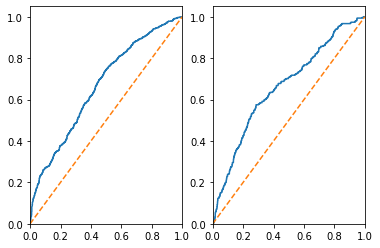

COVID:
Acc:0.592
AUC:0.6636963386309663
F1:0.6169014084507042
Precision:0.7102702702702702
Recall:0.5452282157676348

Severe:
Acc:0.73
AUC:0.6604823239779507
F1:0.34146341463414637
Precision:0.2697495183044316
Recall:0.46511627906976744



In [4]:
# Generate Result Report

resultTag = "stoic2021_resnet18_newpreprocess_v3"
threshold = 0.5

referenceResult = {}
logAns = []
with open(os.path.join("..", "data", "stoic2021", "LabelInfo.pth"), "rb") as f:
    referenceResult = pickle.load(f)

resultPath = os.path.join("..", "data", resultTag)
referenceList0 = []
referenceList1 = []
resultList0 = []
resultList1 = []
for patientName in os.listdir(resultPath):
    if patientName.endswith(".csv"):
        continue
    patientName = int(patientName)
    referenceList0.append(referenceResult[patientName][0])
    referenceList1.append(referenceResult[patientName][1])
    with open(os.path.join(resultPath, str(patientName), "prob.pth"), "rb") as f:
        prob = pickle.load(f)
        prob0 = prob[0].item()
        prob1 = prob[1].item()
        resultList0.append(prob0)
        resultList1.append(prob1)
fpr0, tpr0, _ = skMetrics.roc_curve(referenceList0, resultList0, drop_intermediate=False)
fpr1, tpr1, _ = skMetrics.roc_curve(referenceList1, resultList1, drop_intermediate=False)
auc0 = skMetrics.auc(fpr0, tpr0)
auc1 = skMetrics.auc(fpr1, tpr1)

plt.figure()
plt.subplot(1,2,1)
plt.plot(fpr0, tpr0)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])

plt.subplot(1,2,2)
plt.plot(fpr1, tpr1)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])

plt.show()

binaryResultList0 = [i > threshold for i in resultList0]
binaryResultList1 = [i > threshold for i in resultList1]

accuracy = skMetrics.accuracy_score(referenceList0, binaryResultList0)
f1 = skMetrics.f1_score(referenceList0, binaryResultList0)
precision = skMetrics.precision_score(referenceList0, binaryResultList0)
recall = skMetrics.recall_score(referenceList0, binaryResultList0)
print("COVID:\nAcc:{}\nAUC:{}\nF1:{}\nPrecision:{}\nRecall:{}\n".format(
    accuracy, auc0, f1, precision, recall
))

accuracy = skMetrics.accuracy_score(referenceList1, binaryResultList1)
f1 = skMetrics.f1_score(referenceList1, binaryResultList1)
precision = skMetrics.precision_score(referenceList1, binaryResultList1)
recall = skMetrics.recall_score(referenceList1, binaryResultList1)
print("Severe:\nAcc:{}\nAUC:{}\nF1:{}\nPrecision:{}\nRecall:{}\n".format(
    accuracy, auc1, f1, precision, recall
))

In [ ]:
# Generate all Result Report

def kROC(reference, prob, k = 0.01):
    reference = np.array(reference)
    prob = np.array(prob)

    fprList = []
    tprList = []
    for threshold in np.arange(0, 1.00001, k):
        fakePredict = prob > threshold
        tprList.append((fakePredict * reference).sum() / reference.sum())
        fprList.append(((1 - reference) * fakePredict).sum() / (1 - reference).sum())

    return fprList, tprList       

resultTagList = [
    "TAPVC_classify_softmax_resin_cam0.1_v3_None",
    # "TAPVC_classify_softmax_resin_cam0.1_v3_loss1",
    # "TAPVC_classify_softmax_resin_cam0.1_v3_loss2",
    "TAPVC_classify_softmax_resin_cam0.1_v3"]
resultLabelList = [
    "Baseline",
    # "Loss1",
    # "Loss2",
    "Loss1+Loss2",
]

plt.figure(figsize=(6.4,6.4))
for resultTag, resultLabel in zip(resultTagList, resultLabelList):
    referenceResult = {}
    logAns = []
    with open(os.path.join("..", "data", "tapvc_info.pth"), "rb") as f:
        referenceResult = pickle.load(f)

    resultPath = os.path.join("..", "data", resultTag)
    referenceList = []
    resultList = []
    for patientName in os.listdir(resultPath):
        if patientName.endswith(".csv"):
            continue
        referenceList.append(referenceResult[patientName]["label2"])
        with open(os.path.join(resultPath, patientName, "prob.pth"), "rb") as f:
            prob = pickle.load(f)
            prob = prob[1].item()
            resultList.append(prob)
        logAns.append("{} {} {}".format(patientName, referenceList[-1], resultList[-1]))
    fpr, tpr, _ = skMetrics.roc_curve(referenceList, resultList, drop_intermediate=False)
    # fpr, tpr = kROC(referenceList, resultList, k = 0.00001)
    plt.plot(fpr, tpr, label=resultLabel)

plt.legend()
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim([0.0,1.0])
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.ylim([0.0,1.05])
plt.title("ROC Curves of Baseline Method and Proposed Method")

# plt.show()